In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter

%matplotlib inline

In [2]:
### Hyperparameters
n_epochs = 10
batch_size_train = 64
batch_size_test = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Load the Data

In [3]:
### Get MNIST Data

#train = True pulls from training set train = False pulls from testing data
#Compose() chains multiple transformations together
#ToTensor() transforms PIL image or numpy array to torch tensor
#Normalize() normalize a tensor image with mean and standard deviation (mean, std)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((32, 32)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

### Scale Factor of 1/2
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((32, 32)),
                               torchvision.transforms.RandomRotation((180,180)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)



### Visualize the Data

In [4]:
### Example Data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
### 1000 examples 1 color, 32 by 32
### 1000 target lables that corresponds to an example
print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

Index: 0
Example Shape: torch.Size([100, 1, 32, 32])
Target Shape : torch.Size([100])


<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

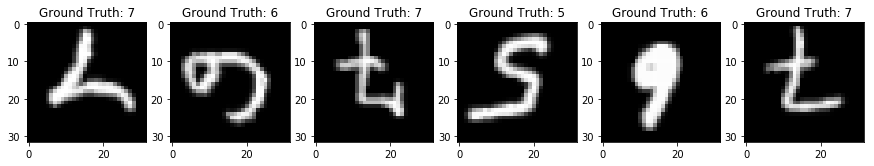

In [6]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

### LeNet CNN

In [7]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet, self).__init__()
        self.c1 = nn.Conv2d(1, 6, 5)  # input channel = 1, output channel = 6, kernel_size = 5
        self.c3 = nn.Conv2d(6, 16, 5)
        self.c5 = nn.Linear(16 * 5 * 5, 120) 
        self.f6 = nn.Linear(120, 84)
        self.OUTPUT = nn.Linear(84, 10)

        
    def forward(self, x):
        out1 = F.max_pool2d(F.relu(self.c1(x)), 2)  # pool size = 2
        out2 = F.max_pool2d(F.relu(self.c3(out1)), 2)
        out2 = out2.view(out2.size()[0], -1)             # x.view == np.reshape
        out3 = F.relu(self.c5(out2))
        out4 = F.relu(self.f6(out3))
        out5 = self.OUTPUT(out4)
        return out5
    
    def name(self):
        return "LeNet"

### Training

In [8]:
model = Lenet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [9]:
### Create the Training Loop
for epoch in range(n_epochs):
    #training
    avg_loss = 0
    
    #loop through the training data
    for batch_idx, (x, label) in enumerate(train_loader):
        optimizer.zero_grad()                              #zero out the gradient for each minibatch
        x, label = Variable(x), Variable(label)
        output = model(x)                                  #get the output of the model fed forward
        loss = loss_function(output, label)                #calculate the loss of the output
        avg_loss = avg_loss * 0.9 + loss.item() * 0.1      #update the avg loss using momentum beta=.9
        loss.backward()                                    #back propagate
        optimizer.step()                                   #update the optimizer
        
        #print the current stats
        if (batch_idx+1) % 200 == 0 or (batch_idx+1) == len(train_loader):
            print ('**** epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx+1, avg_loss))


    #loop through the testing data for validation
    correct_pred = 0
    total_count = 0
    with torch.no_grad():
        for batch_idx, (x, label) in enumerate(test_loader):
            x, label = Variable(x), Variable(label) 
            output = model(x)
            loss = loss_function(output, label)
            _, pred_label = torch.max(output.data, 1)                  #return max of prediction array

            total_count += x.data.size()[0]                            #update total count with batch size
            correct_pred += (pred_label == label.data).sum().item()    #update correct predictions using sum of correct preds

            avg_loss = avg_loss * 0.9 + loss.item() * 0.1              #update loss

            if(batch_idx+1) % 1000 == 0 or (batch_idx+1) == len(test_loader):
                print ('@@@@ epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                    epoch, batch_idx+1, avg_loss, correct_pred * 1.0 / total_count))
            
#### Save the final model
torch.save(model.state_dict(), model.name())

    

**** epoch: 0, batch index: 200, train loss: 0.205657
**** epoch: 0, batch index: 400, train loss: 0.098253
**** epoch: 0, batch index: 600, train loss: 0.108048
**** epoch: 0, batch index: 800, train loss: 0.078844
**** epoch: 0, batch index: 938, train loss: 0.058927
@@@@ epoch: 0, batch index: 100, test loss: 6.957535, acc: 0.324
**** epoch: 1, batch index: 200, train loss: 0.055242
**** epoch: 1, batch index: 400, train loss: 0.041176
**** epoch: 1, batch index: 600, train loss: 0.045930
**** epoch: 1, batch index: 800, train loss: 0.041440
**** epoch: 1, batch index: 938, train loss: 0.034689
@@@@ epoch: 1, batch index: 100, test loss: 7.028849, acc: 0.341
**** epoch: 2, batch index: 200, train loss: 0.044641
**** epoch: 2, batch index: 400, train loss: 0.038156
**** epoch: 2, batch index: 600, train loss: 0.036172
**** epoch: 2, batch index: 800, train loss: 0.029502
**** epoch: 2, batch index: 938, train loss: 0.057412
@@@@ epoch: 2, batch index: 100, test loss: 5.847844, acc: 0

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data)

<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

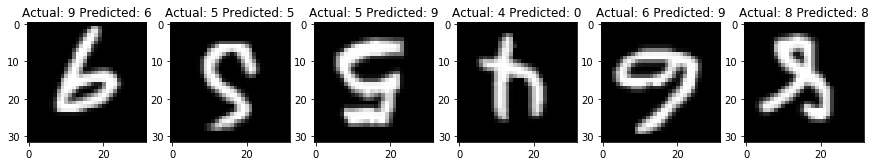

In [11]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Actual: {} Predicted: {}".format(example_targets[i], output.data.max(1, keepdim=True)[1][i].item()))
plt

In [12]:
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data)

<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

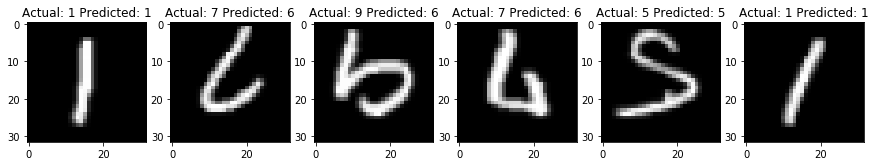

In [13]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Actual: {} Predicted: {}".format(example_targets[i], output.data.max(1, keepdim=True)[1][i].item()))
plt

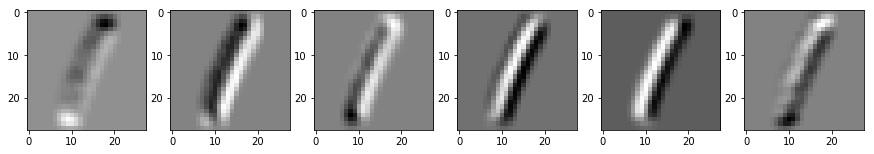

In [14]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.c1.register_forward_hook(get_activation('c1'))
data = example_data[5]

data.unsqueeze_(0)
output = model(data)

act = activation['c1'].squeeze()

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(act[i], cmap='gray')

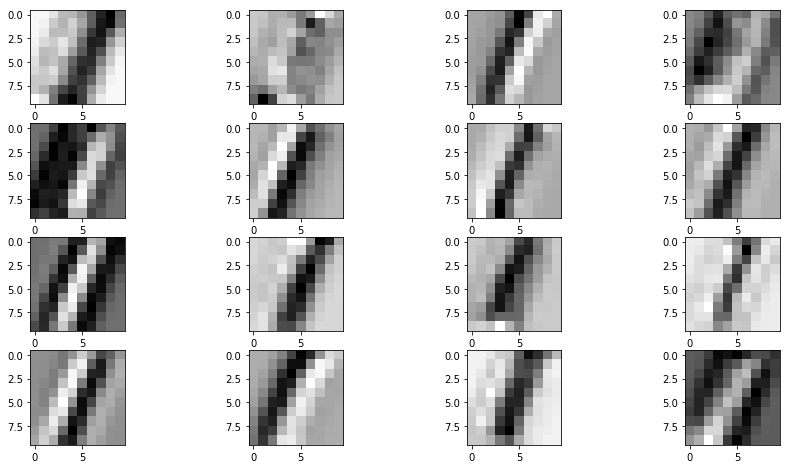

In [15]:
model.c3.register_forward_hook(get_activation('c3'))
data  = example_data[5]
data.unsqueeze_(0)
output = model(data)

act = activation['c3'].squeeze()

fig = plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(act[i], cmap='gray')

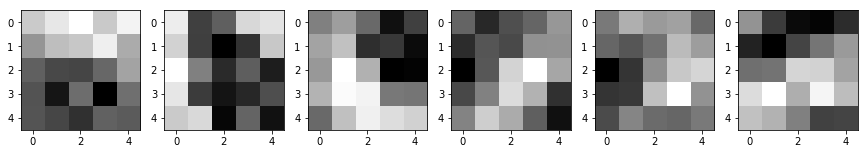

In [16]:
# Visualize conv filter

fig = plt.figure(figsize=(15, 8))

kernels = model.c1.weight.detach()
for idx in range(kernels.size(0)):
    plt.subplot(1,6, idx+1)
    plt.imshow(kernels[idx].squeeze(), cmap='gray')


torch.Size([16, 6, 5, 5])


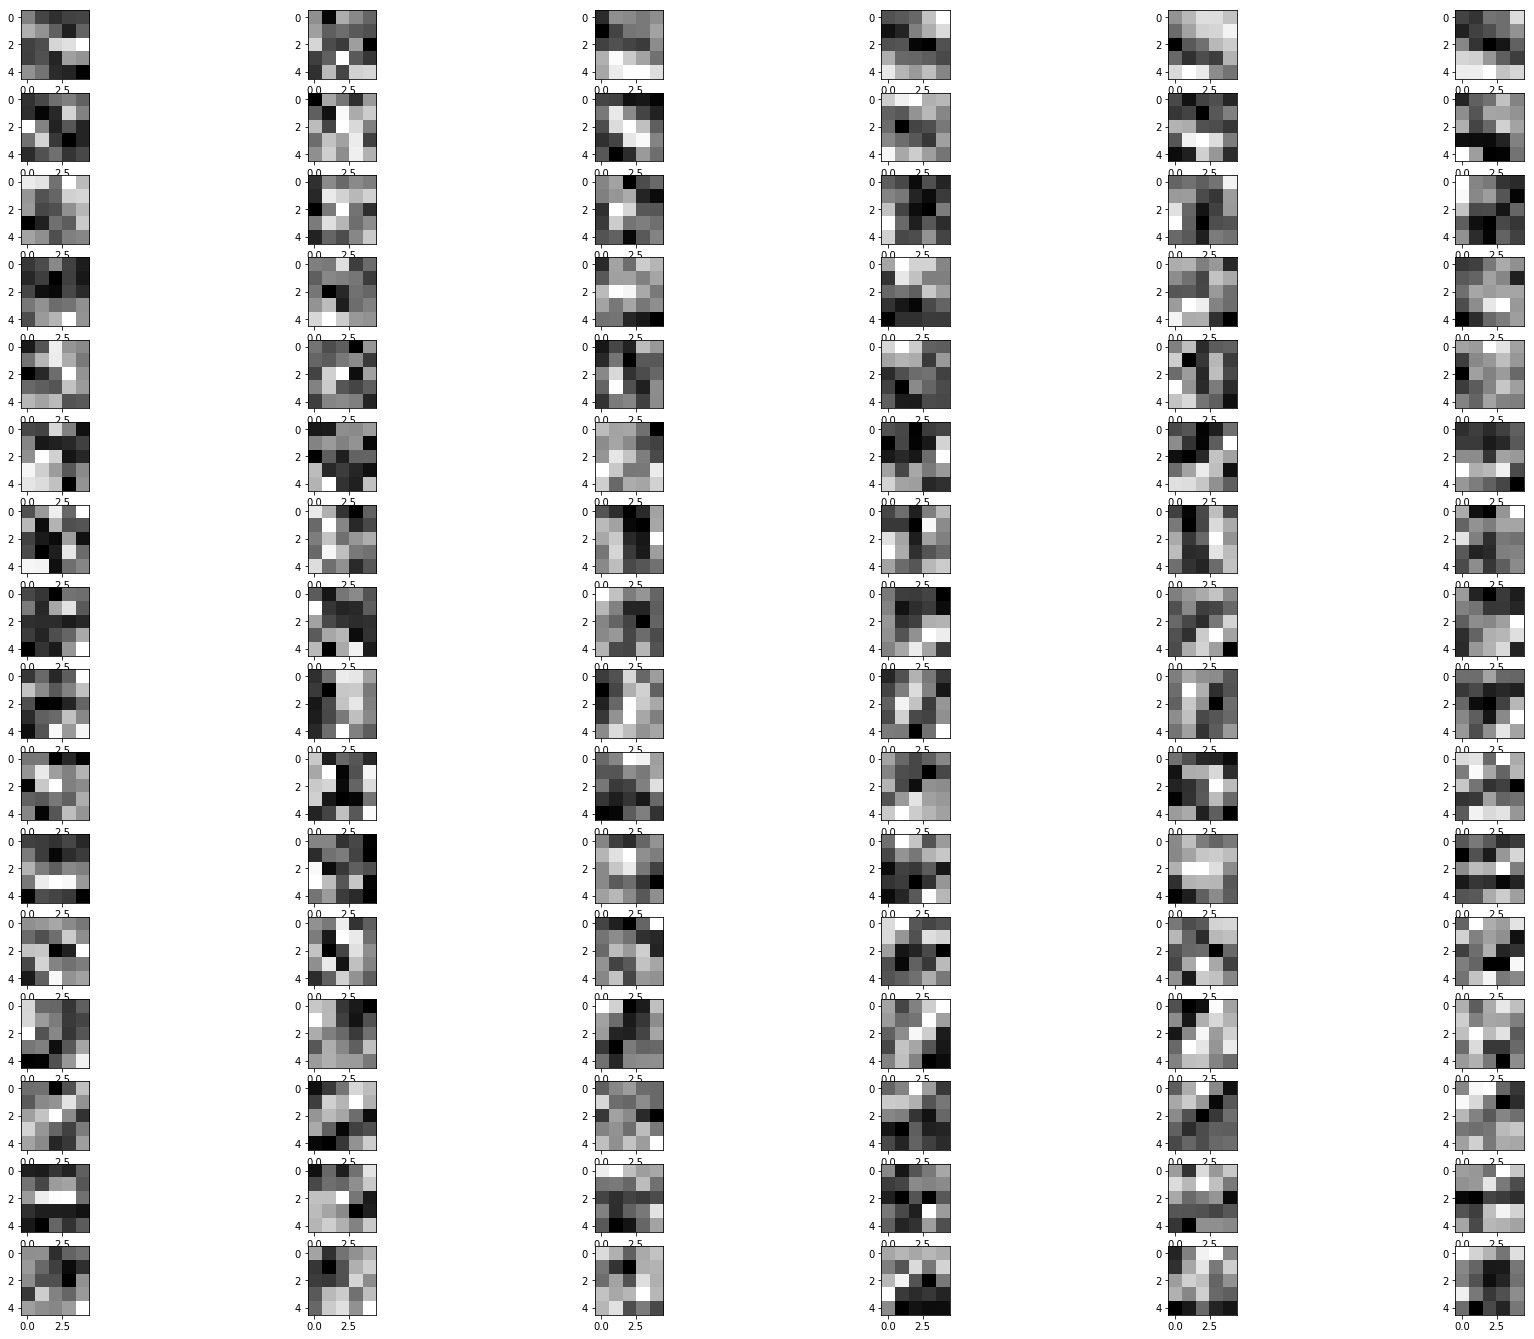

In [17]:
fig = plt.figure(figsize=(30, 24))

kernels = model.c3.weight.detach()
print(kernels.size())

count = 1
for j in range(1,17):
    for idx in range(1,7):
        plt.subplot(16,6, count)
        count += 1
        plt.imshow(kernels[j-1][idx-1].squeeze(), cmap='gray')

In [18]:
#loop through the testing data for validation
zero = []
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []
nine = []

with torch.no_grad():
    for batch_idx, (x, label) in enumerate(test_loader):
        x, label = Variable(x), Variable(label) 
        output = model(x)
        _, pred_label = torch.max(output.data, 1)                  #return max of prediction array
        
        for i in range(len(label)):
            if (int(label[i].item()) == 0):
                zero.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 1):
                one.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 2):
                two.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 3):
                three.append((label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 4):
                four.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 5):
                five.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 6):
                six.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 7):
                seven.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 8):
                eight.append((pred_label[i] == label.data[i]).item())
            elif (int(label[i].item()) == 9):
                nine.append((pred_label[i] == label.data[i]).item())
            else:
                continue

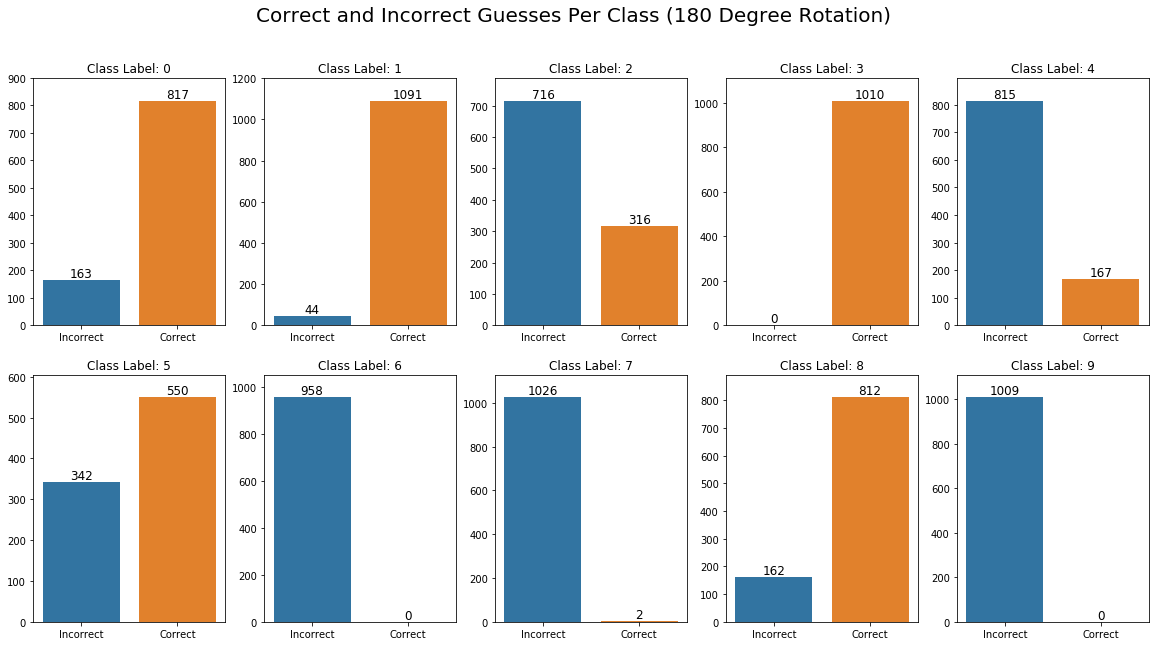

In [19]:
list_of_predictions = [zero, one, two, three, four, five, six, seven, eight, nine]
names_of_lists = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]


fig = plt.figure(figsize=(20,10))
fig.suptitle("Correct and Incorrect Guesses Per Class (180 Degree Rotation)", fontsize=20)

for i in range(1, len(list_of_predictions)+1):
    plt.subplot(2, 5, i).set_title("Class Label: {}".format(names_of_lists[i-1]))
    df = pd.DataFrame( { names_of_lists[i-1] : list_of_predictions[i-1]})
    df[names_of_lists[i-1]].replace([0,1],['Incorrect','Correct'],inplace=True)
    df_count = df[names_of_lists[i-1]].value_counts()
    
    if len(df_count) == 1 and 'Incorrect' in df_count.keys():
        df_count['Correct'] = 0
    elif len(df_count) == 1 and 'Correct' in df_count.keys():
        df_count['Incorrect'] = 0
    
    y_max = df_count.max() 
    g = sns.barplot(df_count.index, df_count.values, order=['Incorrect', 'Correct'])
    g.set_ylim([0,y_max*1.1])
    
    for p in g.patches:
         g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
    

In [20]:
fig.savefig('Class_Compare_Rotate_180.png')

In [21]:
sum_list = 0
for each in list_of_predictions:
    sum_list += len(each)

In [22]:
sum_list

10000